In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# import torch
# print("Torch:", torch.__version__)
# print("CUDA available:", torch.cuda.is_available())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

MODEL_PATH = "/content/drive/MyDrive/checkpoints"

for f in os.listdir(MODEL_PATH):
    print(f)

fasterrcnn_r101_1000imgs.pth


In [ ]:
!pip install torch torchvision opencv-python lxml tqdm scikit-learn

In [ ]:
import os
import cv2
import torch
import random
import numpy as np
import xml.etree.ElementTree as ET

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from sklearn.model_selection import train_test_split

In [ ]:
DEVICE = torch.device("cpu")
print("Using device:", DEVICE)

Using device: cpu


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# class ThyroidDataset(Dataset):
#     def __init__(self, images, img_dir, xml_dir):
#         self.images = images
#         self.img_dir = img_dir
#         self.xml_dir = xml_dir

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img_name = self.images[idx]

#         img_path = os.path.join(self.img_dir, img_name)
#         xml_path = os.path.join(self.xml_dir, img_name.replace(".jpg", ".xml"))

#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         boxes, labels = parse_tn5000_xml(xml_path)

#         # 🚨 CRITICAL — NEVER allow empty boxes
#         if len(boxes) == 0:
#             raise ValueError(f"Empty boxes not allowed: {img_name}")

#         img = F.to_tensor(img)

#         boxes = torch.tensor(boxes, dtype=torch.float32)
#         labels = torch.tensor(labels, dtype=torch.int64)

#         target = {
#             "boxes": boxes,
#             "labels": labels,
#             "image_id": torch.tensor([idx])
#         }

#         return img, target

In [ ]:
CHECKPOINT_PATH = "/content/drive/MyDrive/checkpoints/fasterrcnn_r101_1000imgs.pth"

In [ ]:
# CHANGE THESE PATHS
DATA_ROOT = "/content/drive/MyDrive/TN5000_100"

IMAGE_DIR = os.path.join(DATA_ROOT, "images-1")
XML_DIR   = os.path.join(DATA_ROOT, "xmls-1")

# CHECKPOINT_PATH = "/content/drive/MyDrive/checkpoints/fasterrcnn_checkpoint.pth"

In [ ]:
# def validate_bbox(box, w, h):
#     x1, y1, x2, y2 = box

#     x1 = max(0, min(x1, w - 1))
#     y1 = max(0, min(y1, h - 1))
#     x2 = max(0, min(x2, w - 1))
#     y2 = max(0, min(y2, h - 1))

#     if x2 <= x1 or y2 <= y1:
#         return None

#     return [x1, y1, x2, y2]

In [ ]:
# def parse_tn5000_xml(xml_path, img_w, img_h):
#     tree = ET.parse(xml_path)
#     root = tree.getroot()

#     boxes = []
#     labels = []

#     for obj in root.findall("object"):
#         bnd = obj.find("bndbox")

#         box = [
#             int(float(bnd.find("xmin").text)),
#             int(float(bnd.find("ymin").text)),
#             int(float(bnd.find("xmax").text)),
#             int(float(bnd.find("ymax").text)),
#         ]

#         box = validate_bbox(box, img_w, img_h)
#         if box is None:
#             continue

#         boxes.append(box)
#         labels.append(1)  # binary detection

#     return boxes, labels

In [ ]:
# def safe_augment(img, boxes):
#     # Horizontal flip
#     if random.random() < 0.5:
#         img = torch.flip(img, dims=[2])
#         w = img.shape[2]

#         boxes = boxes.clone()
#         boxes[:, [0, 2]] = w - boxes[:, [2, 0]]

#     # Brightness jitter
#     if random.random() < 0.3:
#         factor = 1.0 + random.uniform(-0.15, 0.15)
#         img = torch.clamp(img * factor, 0, 1)

#     return img, boxes

In [ ]:
# CELL 8 — DATASET CLASS (FINAL, SAFE)

import os
import cv2
import torch
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
from torchvision.transforms import functional as F

# ---------- XML PARSER ----------
def parse_tn5000_xml(xml_path):
    """
    Parses TN5000 XML
    Returns:
        boxes: List[[xmin, ymin, xmax, ymax]]
        labels: List[int] (ALWAYS 1 — foreground)
    """
    boxes = []
    labels = []

    tree = ET.parse(xml_path)
    root = tree.getroot()

    for obj in root.findall("object"):
        bnd = obj.find("bndbox")
        if bnd is None:
            continue

        xmin = int(bnd.find("xmin").text)
        ymin = int(bnd.find("ymin").text)
        xmax = int(bnd.find("xmax").text)
        ymax = int(bnd.find("ymax").text)

        # 🚨 Safety: invalid boxes
        if xmax <= xmin or ymax <= ymin:
            continue

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(1)  # ✅ SINGLE CLASS (thyroid)

    return boxes, labels


# ---------- DATASET ----------
class ThyroidDetectionDataset(Dataset):
    def __init__(self, image_dir, xml_dir):
        self.image_dir = image_dir
        self.xml_dir = xml_dir
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        img_path = os.path.join(self.image_dir, img_name)
        xml_path = os.path.join(self.xml_dir, img_name.replace(".jpg", ".xml"))

        # ---- READ IMAGE ----
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"❌ Failed to read image: {img_name}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ---- READ XML ----
        boxes, labels = parse_tn5000_xml(xml_path)

        # 🚨 CRITICAL CHECK
        if len(boxes) == 0:
            raise ValueError(f"❌ Empty boxes not allowed: {img_name}")

        # ---- TO TENSOR ----
        img = F.to_tensor(img)
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        return img, target


print("✅ ThyroidDetectionDataset loaded successfully")

✅ ThyroidDetectionDataset loaded successfully


In [ ]:
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return [], []
    return tuple(zip(*batch))

In [ ]:
import shutil
import os

BASE_DIR = "/content/data"

if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)
    print("🗑️ Old /content/data deleted")

os.makedirs(BASE_DIR, exist_ok=True)
print("📁 Fresh /content/data created")

🗑️ Old /content/data deleted
📁 Fresh /content/data created


In [ ]:
# ===============================
# CELL — SPLIT DATA + CREATE FOLDERS (FINAL)
# ===============================

import os
import shutil
from sklearn.model_selection import train_test_split

# ---- PATHS (CHANGE ONLY IF NEEDED) ----
DATA_ROOT = "/content/drive/MyDrive/TN5000_100"

IMAGE_DIR = os.path.join(DATA_ROOT, "images-1")
XML_DIR   = os.path.join(DATA_ROOT, "xmls-1")

OUTPUT_DIR = "/content/data"   # working directory inside Colab

# ---- STEP 1: FILTER VALID IMAGE–XML PAIRS ----
all_images = sorted(os.listdir(IMAGE_DIR))

valid_images = []
missing_xml = []

for img in all_images:
    xml_name = img.replace(".jpg", ".xml")
    xml_path = os.path.join(XML_DIR, xml_name)

    if os.path.exists(xml_path):
        valid_images.append(img)
    else:
        missing_xml.append(img)

print(f"✅ Total images found: {len(all_images)}")
print(f"✅ Valid image-XML pairs: {len(valid_images)}")
print(f"❌ Images without XML: {len(missing_xml)}")

if missing_xml:
    print("⚠️ Missing XML examples:", missing_xml[:5])

# ---- STEP 2: SPLIT DATASET (70 / 15 / 15) ----
train_imgs, temp_imgs = train_test_split(
    valid_images, test_size=0.30, random_state=42
)

val_imgs, test_imgs = train_test_split(
    temp_imgs, test_size=0.50, random_state=42
)

print("\n📊 Dataset split:")
print(f"Train: {len(train_imgs)}")
print(f"Val:   {len(val_imgs)}")
print(f"Test:  {len(test_imgs)}")

# ---- STEP 3: CREATE OUTPUT FOLDERS ----
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(OUTPUT_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, split, "xmls"), exist_ok=True)

print("\n📁 Output folders created")

# ---- STEP 4: COPY FILES SAFELY ----
def copy_files(img_list, split):
    copied = 0
    skipped = 0

    for img in img_list:
        xml = img.replace(".jpg", ".xml")

        img_src = os.path.join(IMAGE_DIR, img)
        xml_src = os.path.join(XML_DIR, xml)

        if not os.path.exists(xml_src):
            skipped += 1
            continue

        shutil.copy(img_src, os.path.join(OUTPUT_DIR, split, "images", img))
        shutil.copy(xml_src, os.path.join(OUTPUT_DIR, split, "xmls", xml))
        copied += 1

    print(f"✅ {split.upper()}: copied={copied}, skipped={skipped}")

# ---- STEP 5: COPY DATA ----
copy_files(train_imgs, "train")
copy_files(val_imgs, "val")
copy_files(test_imgs, "test")

print("\n🎉 Data split and folder creation COMPLETE")

✅ Total images found: 1929
✅ Valid image-XML pairs: 1929
❌ Images without XML: 0

📊 Dataset split:
Train: 1350
Val:   289
Test:  290

📁 Output folders created
✅ TRAIN: copied=1350, skipped=0
✅ VAL: copied=289, skipped=0
✅ TEST: copied=290, skipped=0

🎉 Data split and folder creation COMPLETE


In [ ]:
def check_folder(path):
    if not os.path.exists(path):
        raise RuntimeError(f"❌ Folder does not exist: {path}")

    files = os.listdir(path)
    if len(files) == 0:
        raise RuntimeError(f"❌ Folder is EMPTY: {path}")

    print(f"✅ {path} → {len(files)} files")


print("🔍 Checking dataset folders...")

check_folder("/content/data/train/images")
check_folder("/content/data/train/xmls")

check_folder("/content/data/val/images")
check_folder("/content/data/val/xmls")

check_folder("/content/data/test/images")
check_folder("/content/data/test/xmls")

print("✅ Dataset structure OK")

🔍 Checking dataset folders...
✅ /content/data/train/images → 1350 files
✅ /content/data/train/xmls → 1350 files
✅ /content/data/val/images → 289 files
✅ /content/data/val/xmls → 289 files
✅ /content/data/test/images → 290 files
✅ /content/data/test/xmls → 290 files
✅ Dataset structure OK


In [ ]:
print("Train images:", len(os.listdir("/content/data/train/images")))
print("Val images:  ", len(os.listdir("/content/data/val/images")))
print("Test images: ", len(os.listdir("/content/data/test/images")))

Train images: 1350
Val images:   289
Test images:  290


In [ ]:
# CELL 10 — DATASETS

train_dataset = ThyroidDetectionDataset(
    image_dir="/content/data/train/images",
    xml_dir="/content/data/train/xmls"
)

val_dataset = ThyroidDetectionDataset(
    image_dir="/content/data/val/images",
    xml_dir="/content/data/val/xmls"
)

test_dataset = ThyroidDetectionDataset(
    image_dir="/content/data/test/images",
    xml_dir="/content/data/test/xmls"
)

print("Datasets loaded:")
print(f"Train: {len(train_dataset)}")
print(f"Val  : {len(val_dataset)}")
print(f"Test : {len(test_dataset)}")

Datasets loaded:
Train: 1350
Val  : 289
Test : 290


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True
)

print("Dataloaders ready")

Dataloaders ready


In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- BACKBONE: ResNet-101 + FPN ----
backbone = resnet_fpn_backbone(
    backbone_name="resnet101",
    weights="DEFAULT",          # ImageNet pretrained
    trainable_layers=3
)

# ---- MODEL ----
model = FasterRCNN(
    backbone=backbone,
    num_classes=2  # background + thyroid nodule
)

# ---- RPN TUNING (IMPORTANT FOR SMALL OBJECTS) ----
model.rpn.pre_nms_top_n_train = 2000
model.rpn.post_nms_top_n_train = 1000
model.rpn.pre_nms_top_n_test = 1000
model.rpn.post_nms_top_n_test = 500

model.to(DEVICE)

print("✅ Faster R-CNN ResNet-101 (manual backbone) loaded successfully")

✅ Faster R-CNN ResNet-101 (manual backbone) loaded successfully


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/checkpoints/fasterrcnn_r101_1000imgs.pth"

checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state"])

model.eval()
print("✅ Model loaded successfully")

✅ Model loaded successfully


In [ ]:
from PIL import Image
import torchvision.transforms.functional as F

def load_image(img_path):
    image = Image.open(img_path).convert("RGB")
    image = F.to_tensor(image)
    return image

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.AdamW(
    params,
    lr=1e-4,
    weight_decay=1e-4
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.1
)

In [ ]:
# =========================
# C17 — CHECKPOINT UTILITIES
# =========================

import torch
import os

def save_checkpoint(model, optimizer, epoch, path):
    """
    Save model + optimizer state
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)

    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict()
    }, path)

    print(f"💾 Checkpoint saved → Epoch {epoch+1}")


def load_checkpoint(model, optimizer, path):
    """
    Load checkpoint if exists
    Returns epoch to resume from
    """
    if not os.path.exists(path):
        print("🆕 No checkpoint found. Starting from epoch 0.")
        return 0

    checkpoint = torch.load(path, map_location=DEVICE)

    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])

    start_epoch = checkpoint["epoch"] + 1
    print(f"🔄 Resuming training from epoch {start_epoch}")

    return start_epoch

In [ ]:
# # CELL — VALIDATION LOOP (FIXED)

# import torch

# def validate(model, val_loader):
#     model.train()   # IMPORTANT: keep train mode for loss computation

#     total_loss = 0.0
#     valid_batches = 0

#     with torch.no_grad():
#         for images, targets in val_loader:
#             images = [img.to(DEVICE) for img in images]
#             targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

#             loss_dict = model(images, targets)  # dict in train mode
#             losses = sum(loss for loss in loss_dict.values())

#             if torch.isnan(losses) or torch.isinf(losses):
#                 continue

#             total_loss += losses.item()
#             valid_batches += 1

#     if valid_batches == 0:
#         return float("inf")

#     return total_loss / valid_batches

In [ ]:
# def load_checkpoint(model, optimizer, path):
#     if not os.path.exists(path):
#         return 0

#     checkpoint = torch.load(path, map_location=DEVICE)
#     model.load_state_dict(checkpoint["model"])
#     optimizer.load_state_dict(checkpoint["optimizer"])
#     return checkpoint["epoch"] + 1

In [ ]:
# sample = train_dataset[0]
# print(type(sample))
# print(sample[0].shape)   # Image tensor
# print(sample[1].keys())  # Target keys

<class 'tuple'>
torch.Size([3, 500, 718])
dict_keys(['boxes', 'labels', 'image_id'])


In [ ]:
import os

CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("✅ Checkpoint directory ready:", CHECKPOINT_DIR)

✅ Checkpoint directory ready: /content/drive/MyDrive/checkpoints


In [ ]:
# ============================
# SANITY CHECK: OVERFIT 1 IMAGE
# ============================

model.train()

# ---- TAKE ONLY 1 IMAGE ----
single_img, single_target = train_dataset[0]

single_img = single_img.to(DEVICE)
single_target = {
    k: v.to(DEVICE) for k, v in single_target.items()
}

# ---- TRAIN FOR MANY STEPS ----
print("🚀 Starting 1-image overfit test...")

for step in range(300):
    optimizer.zero_grad()

    loss_dict = model([single_img], [single_target])
    losses = sum(loss for loss in loss_dict.values())

    losses.backward()
    optimizer.step()

    if step % 25 == 0:
        print(
            f"Step {step:03d} | "
            f"Total Loss: {losses.item():.4f} | "
            + " ".join([f"{k}:{v.item():.3f}" for k, v in loss_dict.items()])
        )

print("✅ Overfit training done")

🚀 Starting 1-image overfit test...
Step 000 | Total Loss: 1.1418 | loss_classifier:0.467 loss_box_reg:0.001 loss_objectness:0.667 loss_rpn_box_reg:0.006
Step 025 | Total Loss: 0.1144 | loss_classifier:0.045 loss_box_reg:0.048 loss_objectness:0.021 loss_rpn_box_reg:0.000
Step 050 | Total Loss: 0.0306 | loss_classifier:0.012 loss_box_reg:0.017 loss_objectness:0.001 loss_rpn_box_reg:0.001
Step 075 | Total Loss: 0.0430 | loss_classifier:0.022 loss_box_reg:0.020 loss_objectness:0.001 loss_rpn_box_reg:0.000
Step 100 | Total Loss: 0.0380 | loss_classifier:0.027 loss_box_reg:0.010 loss_objectness:0.001 loss_rpn_box_reg:0.000
Step 125 | Total Loss: 0.0264 | loss_classifier:0.008 loss_box_reg:0.018 loss_objectness:0.001 loss_rpn_box_reg:0.000
Step 150 | Total Loss: 0.0225 | loss_classifier:0.011 loss_box_reg:0.011 loss_objectness:0.001 loss_rpn_box_reg:0.000
Step 175 | Total Loss: 0.0093 | loss_classifier:0.002 loss_box_reg:0.006 loss_objectness:0.001 loss_rpn_box_reg:0.000
Step 200 | Total Loss

In [ ]:
# =========================
# C21 — VALIDATION FUNCTION
# =========================

@torch.no_grad()
def validate_model(model, loader):
    model.train()  # REQUIRED for Faster R-CNN loss
    total_loss = 0.0
    count = 0

    for images, targets in loader:
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        if torch.isfinite(losses):
            total_loss += losses.item()
            count += 1

    return total_loss / max(count, 1)

In [ ]:
# =========================
# C20 — TRAINING LOOP
# =========================

num_epochs = 20
start_epoch = load_checkpoint(model, optimizer, CHECKPOINT_PATH)

for epoch in range(start_epoch, num_epochs):

    model.train()
    running_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"\n🟢 Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}")

    save_checkpoint(model, optimizer, epoch, CHECKPOINT_PATH)

    if (epoch + 1) % 5 == 0:
        val_loss = validate_model(model, val_loader)
        print(f"🔵 Validation Loss @ Epoch {epoch+1}: {val_loss:.4f}")

🔄 Resuming training from epoch 5


Epoch 6/20: 100%|██████████| 675/675 [08:52<00:00,  1.27it/s]



🟢 Epoch [6/20] Train Loss: 0.1269
💾 Checkpoint saved → Epoch 6


Epoch 7/20: 100%|██████████| 675/675 [08:54<00:00,  1.26it/s]



🟢 Epoch [7/20] Train Loss: 0.1213
💾 Checkpoint saved → Epoch 7


Epoch 8/20: 100%|██████████| 675/675 [08:55<00:00,  1.26it/s]



🟢 Epoch [8/20] Train Loss: 0.1084
💾 Checkpoint saved → Epoch 8


Epoch 9/20: 100%|██████████| 675/675 [08:55<00:00,  1.26it/s]



🟢 Epoch [9/20] Train Loss: 0.1044
💾 Checkpoint saved → Epoch 9


Epoch 10/20: 100%|██████████| 675/675 [08:54<00:00,  1.26it/s]



🟢 Epoch [10/20] Train Loss: 0.0992
💾 Checkpoint saved → Epoch 10
🔵 Validation Loss @ Epoch 10: 0.1467


Epoch 11/20: 100%|██████████| 675/675 [08:54<00:00,  1.26it/s]



🟢 Epoch [11/20] Train Loss: 0.0925
💾 Checkpoint saved → Epoch 11


Epoch 12/20: 100%|██████████| 675/675 [08:54<00:00,  1.26it/s]



🟢 Epoch [12/20] Train Loss: 0.0959
💾 Checkpoint saved → Epoch 12


Epoch 13/20: 100%|██████████| 675/675 [08:55<00:00,  1.26it/s]



🟢 Epoch [13/20] Train Loss: 0.0915
💾 Checkpoint saved → Epoch 13


Epoch 14/20: 100%|██████████| 675/675 [08:56<00:00,  1.26it/s]



🟢 Epoch [14/20] Train Loss: 0.0753
💾 Checkpoint saved → Epoch 14


Epoch 15/20: 100%|██████████| 675/675 [08:55<00:00,  1.26it/s]



🟢 Epoch [15/20] Train Loss: 0.0659
💾 Checkpoint saved → Epoch 15
🔵 Validation Loss @ Epoch 15: 0.1883


Epoch 16/20: 100%|██████████| 675/675 [08:55<00:00,  1.26it/s]



🟢 Epoch [16/20] Train Loss: 0.0672
💾 Checkpoint saved → Epoch 16


Epoch 17/20: 100%|██████████| 675/675 [08:55<00:00,  1.26it/s]



🟢 Epoch [17/20] Train Loss: 0.0650
💾 Checkpoint saved → Epoch 17


Epoch 18/20: 100%|██████████| 675/675 [08:56<00:00,  1.26it/s]



🟢 Epoch [18/20] Train Loss: 0.0661
💾 Checkpoint saved → Epoch 18


Epoch 19/20: 100%|██████████| 675/675 [08:55<00:00,  1.26it/s]



🟢 Epoch [19/20] Train Loss: 0.0576
💾 Checkpoint saved → Epoch 19


Epoch 20/20: 100%|██████████| 675/675 [08:55<00:00,  1.26it/s]



🟢 Epoch [20/20] Train Loss: 0.0506
💾 Checkpoint saved → Epoch 20
🔵 Validation Loss @ Epoch 20: 0.2439


In [ ]:
# =========================
# PREPARE SINGLE IMAGE FOR INFERENCE
# =========================

model.eval()

# Pick ONE image from validation or test set
img_path = os.path.join("/content/data/val/images", os.listdir("/content/data/val/images")[0])
xml_path = img_path.replace("images", "xmls").replace(".jpg", ".xml")

# Load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert to tensor
single_img = F.to_tensor(img).to(DEVICE)

print("✅ single_img ready for inference")

✅ single_img ready for inference


In [ ]:
# ============================
# SANITY CHECK: INFERENCE
# ============================

model.eval()

with torch.no_grad():
    outputs = model([single_img])

out = outputs[0]

print("\n🧪 SANITY CHECK RESULTS")
print("Boxes:", out["boxes"].cpu().numpy())
print("Scores:", out["scores"].cpu().numpy())
print("Labels:", out["labels"].cpu().numpy())


🧪 SANITY CHECK RESULTS
Boxes: [[313.93057   81.99096  341.01392  104.926384]]
Scores: [0.74018824]
Labels: [1]


In [ ]:
@torch.no_grad()
def predict_single_bbox(model, image, device, conf_threshold=0.5):
    """
    Returns:
        bbox  -> [xmin, ymin, xmax, ymax] or None
        score -> float or None
    """
    model.eval()

    image = image.to(device)
    outputs = model([image])[0]

    boxes = outputs["boxes"]
    scores = outputs["scores"]

    if len(scores) == 0:
        return None, None

    # Pick highest confidence box
    max_idx = scores.argmax()
    max_score = scores[max_idx].item()

    if max_score < conf_threshold:
        return None, None

    bbox = boxes[max_idx].cpu().tolist()

    return bbox, max_score


In [ ]:
import os
import random

TEST_IMG_DIR = "/content/data/test/images"

# pick random image
img_name = random.choice(os.listdir(TEST_IMG_DIR))
TEST_IMAGE = os.path.join(TEST_IMG_DIR, img_name)

print("🖼️ Selected test image:", TEST_IMAGE)

single_img = load_image(TEST_IMAGE)

bbox, score = predict_single_bbox(
    model=model,
    image=single_img,
    device=DEVICE,
    conf_threshold=0.5
)

print("📦 BBox:", bbox)
print("🎯 Confidence:", score)

🖼️ Selected test image: /content/data/test/images/002076.jpg
📦 BBox: [136.777587890625, 116.39154052734375, 437.58270263671875, 323.2301330566406]
🎯 Confidence: 0.986690878868103


In [ ]:
!ls /content

drive  sample_data


In [ ]:
!ls /content/data


ls: cannot access '/content/data': No such file or directory


In [ ]:
!ls /content/drive/MyDrive

 0_progress_TN5000.txt	       DDTI_Processed_Dataset
 0.zip			       images
 1_BB_TN5000_Raw	       manual_check
 1.Pre-processing_DDTI.ipynb   models
 1.zip			       Seggregated_Dataset
 2.DDTi_Preprocess.ipynb       thyroid_dataset
 2_Preprocessed_DS_TN5000      TIRADS
 3_Augmentated_DS_TN5000       TN5000_100
 checkpoints		       TN5000_forReview
'Colab Notebooks'	       TN5000_Pre-processed_data
 DDTI			       Untitled0.ipynb
 DDTI_Augmentation.ipynb       Xception
 DDTI_Augmented_Dataset        xmls


In [ ]:
bbox, score = predict_single_bbox(
    model=model,
    image=single_img,
    device=DEVICE,
    conf_threshold=0.5
)

print("Final BBox:", bbox)
print("Confidence:", score)

NameError: name 'single_img' is not defined

In [ ]:
import os
os.makedirs("/content/drive/MyDrive/models", exist_ok=True)

In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/fasterrcnn_r101_thyroid.pth"

torch.save(model.state_dict(), MODEL_SAVE_PATH)

print("✅ Model saved for deployment")

✅ Model saved for deployment


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



🖼️ Image 1
📦 Boxes:
[[284.29788 153.55507 365.99786 202.35956]]
📊 Scores:
[0.99207485]


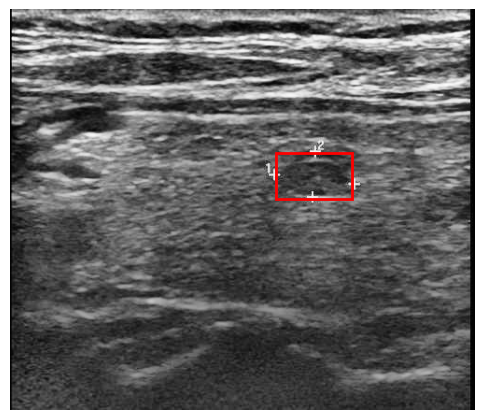


🖼️ Image 2
📦 Boxes:
[[ 91.59242  65.77755 456.81302 350.93335]]
📊 Scores:
[0.9952943]


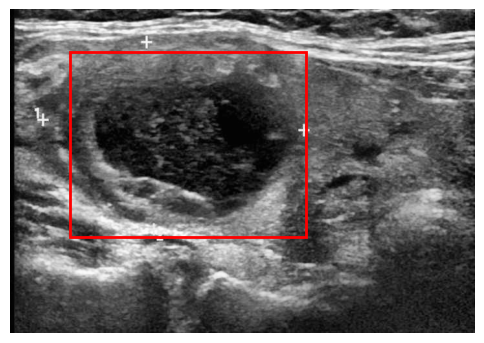


🖼️ Image 3
📦 Boxes:
[[202.5983    62.868187 397.8234   275.5557  ]]
📊 Scores:
[0.9487156]


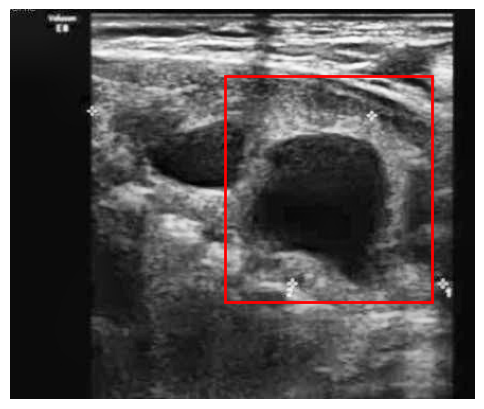


🖼️ Image 4
📦 Boxes:
[[379.3959  136.57564 565.3331  216.97899]]
📊 Scores:
[0.9864218]


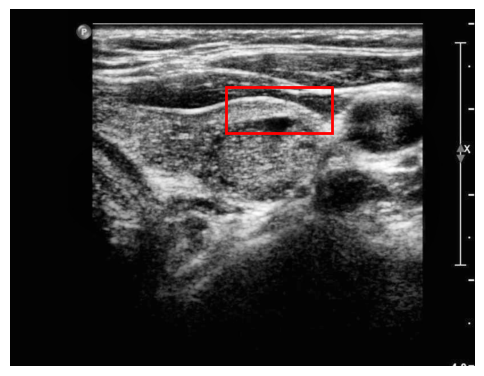


🖼️ Image 5
📦 Boxes:
[[311.31808  73.00187 554.1278  189.68553]]
📊 Scores:
[0.9805542]


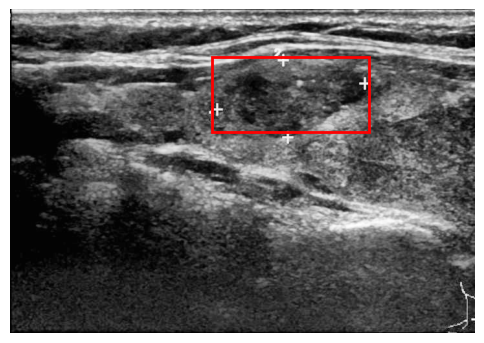


🖼️ Image 6
📦 Boxes:
[[310.64285 159.67403 398.17923 217.09494]]
📊 Scores:
[0.84921134]


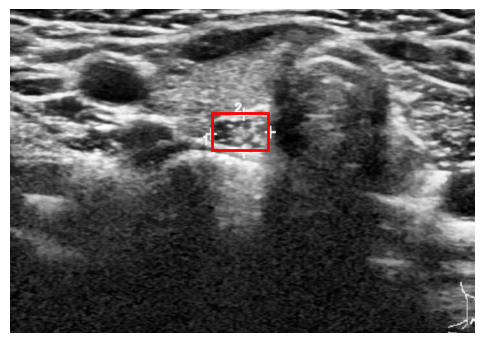


🖼️ Image 7
📦 Boxes:
[[247.14793  68.43151 340.62964 162.63054]
 [139.9667   91.73768 251.83958 202.61996]]
📊 Scores:
[0.9636281  0.89019763]


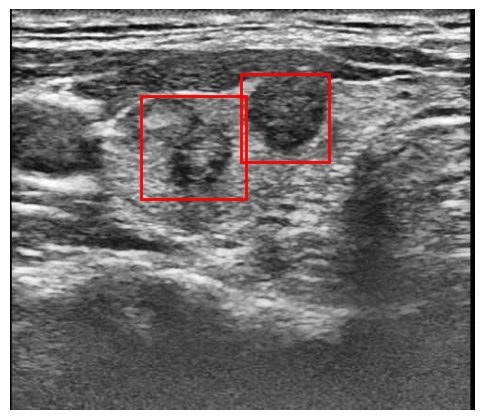


🖼️ Image 8
📦 Boxes:
[[240.14934 164.69931 322.44037 259.88544]]
📊 Scores:
[0.90597713]


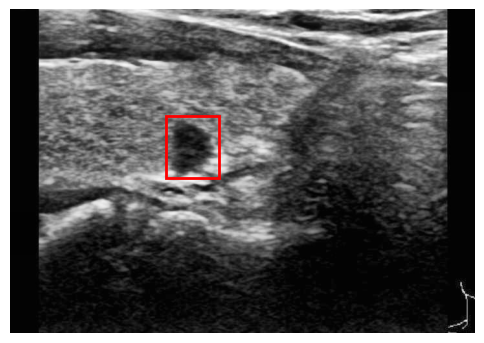


🖼️ Image 9
📦 Boxes:
[[353.49518 151.85701 390.82974 184.00099]]
📊 Scores:
[0.99369156]


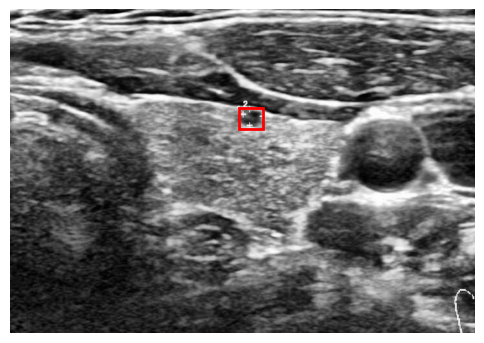


🖼️ Image 10
📦 Boxes:
[[449.47784  114.27001  513.1668   186.47484 ]
 [ 75.534676  96.794586 392.79263  398.97064 ]]
📊 Scores:
[0.9950439 0.5379139]


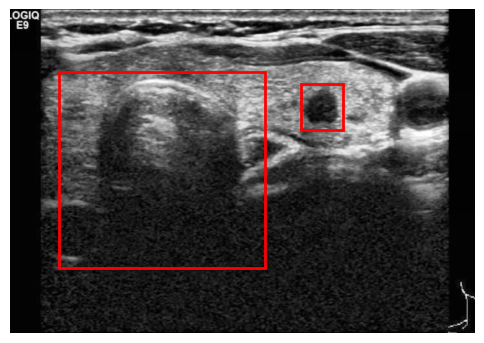

In [ ]:
# =========================
# C23 — FINAL TESTING
# =========================

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

@torch.no_grad()
def final_test(model, test_loader, score_thresh=0.3, max_images=10):
    """
    Runs inference on test set
    """
    model.eval()
    shown = 0

    for images, targets in test_loader:
        images = [img.to(DEVICE) for img in images]

        outputs = model(images)

        for i in range(len(outputs)):
            if shown >= max_images:
                return

            output = outputs[i]
            boxes = output["boxes"].cpu()
            scores = output["scores"].cpu()
            labels = output["labels"].cpu()

            keep = scores >= score_thresh
            boxes = boxes[keep]
            scores = scores[keep]

            print(f"\n🖼️ Image {shown+1}")
            print(f"📦 Boxes:\n{boxes.numpy()}")
            print(f"📊 Scores:\n{scores.numpy()}")

            # ---- VISUALIZE ----
            img = images[i].cpu()
            img = TF.to_pil_image(img)

            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            ax = plt.gca()

            for box in boxes:
                x1, y1, x2, y2 = box
                rect = plt.Rectangle(
                    (x1, y1),
                    x2 - x1,
                    y2 - y1,
                    fill=False,
                    color="red",
                    linewidth=2
                )
                ax.add_patch(rect)

            plt.axis("off")
            plt.show()

            shown += 1


# 🔥 RUN FINAL TEST
final_test(
    model=model,
    test_loader=test_loader,
    score_thresh=0.3,
    max_images=10
)

In [ ]:
@torch.no_grad()
def validate(model, loader):
    model.eval()
    total_loss = 0
    count = 0

    for images, targets in loader:
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        if torch.isfinite(losses):
            total_loss += losses.item()
            count += 1

    return total_loss / max(count, 1)

In [ ]:
def validate_model(model, val_loader, device):
    model.train()  # REQUIRED for Faster R-CNN loss
    total_loss = 0.0

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

    return total_loss / len(val_loader)


val_loss = validate_model(model, val_loader, device)
print(f"✅ Final Validation Loss: {val_loss:.4f}")

In [ ]:
import torch
import os

FINAL_MODEL_PATH = "/content/drive/MyDrive/fasterrcnn_resnet101_tn5000.pt"

# Ensure directory exists
os.makedirs(os.path.dirname(FINAL_MODEL_PATH), exist_ok=True)

# Save only model weights (BEST PRACTICE)
torch.save(model.state_dict(), FINAL_MODEL_PATH)

print(f"✅ Model successfully saved to:\n{FINAL_MODEL_PATH}")

✅ Model successfully saved to:
/content/drive/MyDrive/fasterrcnn_resnet101_tn5000.pt


In [ ]:
test_state = torch.load(FINAL_MODEL_PATH)
print("Keys in saved model:", list(test_state.keys())[:5])

Keys in saved model: ['backbone.body.conv1.weight', 'backbone.body.bn1.weight', 'backbone.body.bn1.bias', 'backbone.body.bn1.running_mean', 'backbone.body.bn1.running_var']


In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

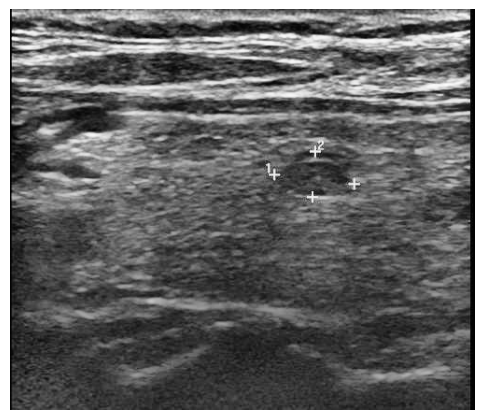

In [ ]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

model.eval()

for images, targets in val_loader:
    images = [img.to(DEVICE) for img in images]

    with torch.no_grad():
        outputs = model(images)

    img = images[0].cpu()
    pred = outputs[0]

    plt.figure(figsize=(6,6))
    plt.imshow(F.to_pil_image(img))
    plt.axis("off")

    for box, score in zip(pred["boxes"], pred["scores"]):
        if score > 0.5:
            x1, y1, x2, y2 = box.int().tolist()
            plt.gca().add_patch(
                plt.Rectangle(
                    (x1, y1),
                    x2 - x1,
                    y2 - y1,
                    fill=False,
                    edgecolor="red",
                    linewidth=2
                )
            )

    plt.show()
    break  # show only one image

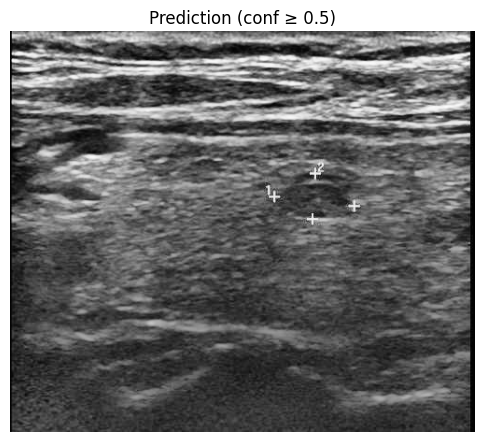

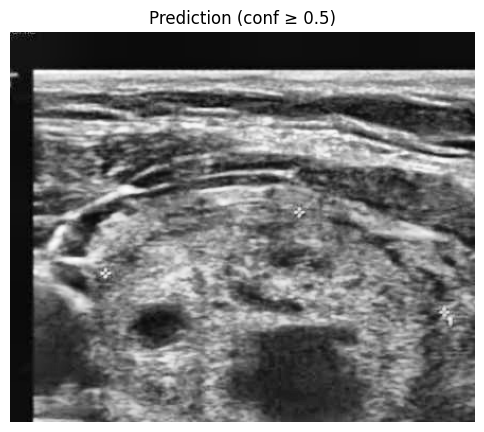

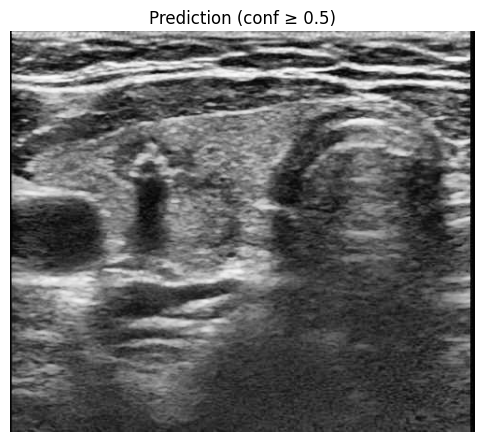

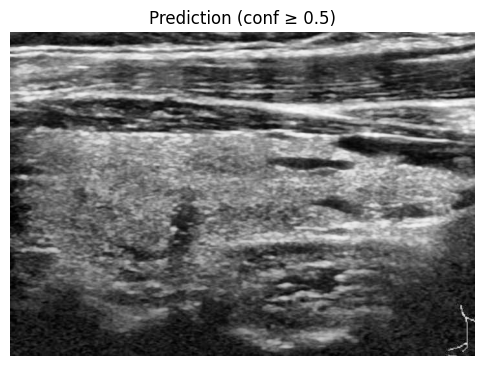

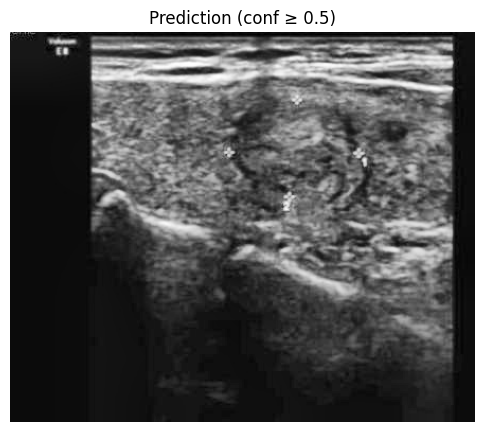

In [ ]:
import torch
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

model.eval()

NUM_IMAGES = 5
CONF_THRESH = 0.5
shown = 0

with torch.no_grad():
    for images, targets in val_loader:
        images = [img.to(DEVICE) for img in images]
        outputs = model(images)

        for img, pred in zip(images, outputs):
            img = img.cpu()

            plt.figure(figsize=(6, 6))
            plt.imshow(F.to_pil_image(img))
            plt.axis("off")

            boxes = pred["boxes"]
            scores = pred["scores"]

            for box, score in zip(boxes, scores):
                if score >= CONF_THRESH:
                    x1, y1, x2, y2 = box.int().tolist()
                    plt.gca().add_patch(
                        plt.Rectangle(
                            (x1, y1),
                            x2 - x1,
                            y2 - y1,
                            fill=False,
                            edgecolor="red",
                            linewidth=2
                        )
                    )

            plt.title(f"Prediction (conf ≥ {CONF_THRESH})")
            plt.show()

            shown += 1
            if shown >= NUM_IMAGES:
                break

        if shown >= NUM_IMAGES:
            break


🖼️ Image name: 000020.jpg

📊 Total predictions: 0
Scores: []

📦 Bounding Boxes:
⚠️ No boxes drawn — model confidence still low


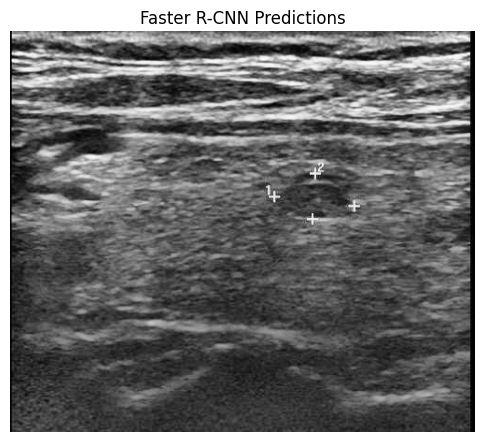

In [ ]:
import os
import torch
import cv2
import matplotlib.pyplot as plt

model.eval()

# ---- CONFIG ----
VAL_IMAGE_DIR = "/content/data/val/images"
CONF_THRESH = 0.0      # TEMPORARILY disable threshold
TOP_K = 5              # show top 5 predictions

# ---- PICK IMAGE ----
image_name = sorted(os.listdir(VAL_IMAGE_DIR))[0]
image_path = os.path.join(VAL_IMAGE_DIR, image_name)

print(f"\n🖼️ Image name: {image_name}")

# ---- LOAD IMAGE ----
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
img_tensor = img_tensor.to(DEVICE)

# ---- INFERENCE ----
with torch.no_grad():
    output = model([img_tensor])[0]

boxes = output["boxes"].cpu()
scores = output["scores"].cpu()
labels = output["labels"].cpu()

print(f"\n📊 Total predictions: {len(boxes)}")
print("Scores:", scores.tolist())

# ---- VISUALIZE ----
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")

shown = 0
print("\n📦 Bounding Boxes:")
for i in range(len(boxes)):
    if shown >= TOP_K:
        break

    score = scores[i].item()
    if score < CONF_THRESH:
        continue

    x1, y1, x2, y2 = boxes[i].int().tolist()

    print(f"Box {shown+1}:")
    print(f"  xmin={x1}, ymin={y1}, xmax={x2}, ymax={y2}")
    print(f"  confidence={score:.4f}")

    plt.gca().add_patch(
        plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            edgecolor="red",
            linewidth=2
        )
    )

    shown += 1

if shown == 0:
    print("⚠️ No boxes drawn — model confidence still low")

plt.title("Faster R-CNN Predictions")
plt.show()

In [ ]:
print(loss_dict)

{'loss_classifier': tensor(0., device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0., device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0010, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)}
